In [63]:
from arcgis.gis import GIS

In [64]:
portal = GIS('http://p132ipp.img.com.br/portal', 'portaladmin', 'portaladmin1')

In [65]:
agol = GIS('http://imagem.maps.arcgis.com', 'mpontes_imagem', '@Imagem123')

In [66]:
app_item = portal.content.get('630ef10e0e4e48df8047c2d5095d477d')

In [67]:
app_item

<Item title:"WebMap-LimiteBrasil-APP" type:Web Mapping Application owner:portaladmin>

In [69]:
file_path = app_item.download()

In [71]:
import json

In [72]:
with open(file_path) as json_file:  
    data = json.load(json_file)

### Buscar recursivamente qualquer url de servico com endereco do portal

In [169]:
def visit_keys_portal_url(data, portal_url):
        portal_url_arr = []
        if not type(data) == dict:
            return portal_url_arr
        keys = list(data.keys())
        for key in keys:
            curr = data[key]
            if isinstance(curr, str):
                url_pattern = '^https?://([^/]*)'
                re_match = re.findall(url_pattern, curr)
                if len(re_match):
                    url_test = re_match[0]
                    if url_test in portal_url:
                        portal_url_arr.append(curr)
                continue
            if type(curr) in [list, tuple]:
                for i_curr in curr:
                    portal_url_arr = portal_url_arr + visit_keys_portal_url(i_curr, portal_url)
            else:
                portal_url_arr = portal_url_arr + visit_keys_portal_url(curr, portal_url)
        return portal_url_arr

In [170]:
visit_keys_portal_url(data, data['portalUrl'])

['http://p132ipp.img.com.br/portal',
 'http://p132ipp.img.com.br/portal/',
 'https://p132ipp.img.com.br/arcgis/rest/services/LimiteBrasilBanco/FeatureServer/0',
 'https://p132ipp.img.com.br/arcgis/rest/services/LimiteBrasilBanco/FeatureServer/0',
 'https://p132ipp.img.com.br/arcgis/rest/services/LimiteBrasilBanco/FeatureServer/0',
 'http://p132ipp.img.com.br/portal/sharing/proxy']

In [173]:
data['map']['itemId']

'66c682128a5f4635b560b4e7db0f5dd8'

### Busca WebMap do portal para obter detalhes, para buscar webmap equivalente no AGOL

In [174]:
webmap_item = portal.content.get(data['map']['itemId'])

<Item title:"WebMap-LimiteBrasil" type:Web Map owner:portaladmin>
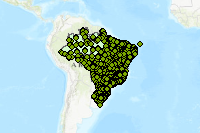

In [175]:
webmap_item

### Busca webmap equivalente no agol

No teste abaixo, existe o webmap equivalente pois foi migrado anteriormente

In [186]:
query = '(name: "%s" OR title:"%s") AND (type: "Web Map")' % (webmap_item.title, webmap_item.title)                        
rset = agol.content.search(query)
rset

[<Item title:"WebMap-LimiteBrasil" type:Web Map owner:mpontes_imagem>]

<Item title:"WebMap-LimiteBrasil" type:Web Map owner:mpontes_imagem>
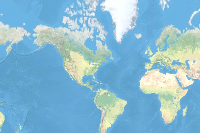

In [189]:
rset[0]

In [190]:
rset[0].id

'3ab747e363964b98ba052a5facd69363'

### Substituindo URLs do Web Map Application de origem

#### Obtem URL amostra para substituicao das urls existentes.

===========


PREMISSAS

1- Webmap ja foi migrado em outra operacao

2- Considerando apenas 1 servico por webmap

In [194]:
def get_url_sample(webmap_target):
    from arcgis.mapping import WebMap
    wm = WebMap(webmap_target)
    return wm.layers[0].url

wm_agol_item = agol.content.get(rset[0].id)
sample_url = get_url_sample(wm_agol_item)

sample_url

'https://services.arcgis.com/qFQYQQeTXZSPY7Fs/arcgis/rest/services/LimiteBrasilBanco/FeatureServer/1'

#### A partir da amostra de URL extrai url base e nome do servico

In [209]:
pattern = re.compile("rest\/services\/(.*)\/(FeatureServer|MapServer)")
match = pattern.findall(sample_url)
if not len(match) or not len(match[0]):
    raise Exception('Invalid sample URL')
service_name = match[0][0]
if '/' in service_name:
    service_name = service_name.split('/')[1]
service_name

'LimiteBrasilBanco'

In [210]:
sample_url = re.findall('(.*)' + service_name + '\/(FeatureServer|MapServer)', sample_url)[0][0]
sample_url

'https://services.arcgis.com/qFQYQQeTXZSPY7Fs/arcgis/rest/services/'

#### A principio 3 tipos de URL
1- Portal URL

3- URLs de servicos

4- Proxy URL

### Efetua substituicao com base no nome do servico e url de amostra

In [211]:
def replace_by_agol_url(data, agol_url, portal_url, sample_agol_svc, svc_within_agol_webmap):
        
        if not type(data) == dict:
            return portal_url_arr
        keys = list(data.keys())
        
        for key in keys:
            
            
            curr = data[key]
            if isinstance(curr, str):
                
                if curr == portal_url:
                    # replace to agol_url
                    curr = agol_url
                else:
                    
                    pattern = re.compile("rest\/services\/(.*)\/(FeatureServer|MapServer)")
                    match = pattern.findall(curr)
                    if not len(match) or not len(match[0]):
                        continue
                        
                    service_name = match[0][0]
                    if '/' in service_name:
                        service_name = service_name.split('/')[1]
                    
                    if service_name != svc_within_agol_webmap:
                        print('Skipping service name %s. Expected %s' % (service_name, svc_within_agol_webmap))
                    
                    portal_to_replace = re.findall('(.*)' + service_name + '\/(FeatureServer|MapServer)', curr)[0][0]
                    curr = curr.replace(portal_to_replace, sample_agol_svc)
                        
                continue
            
            
            if type(curr) in [list, tuple]:
                for i_curr in curr:
                    visit_keys_portal_url(i_curr, portal_url)
            else:
                visit_keys_portal_url(curr, portal_url)

In [205]:
url_t = 'https://p132ipp.img.com.br/arcgis/rest/services/SIG/LimiteBrasilBanco/FeatureServer/0'

In [206]:
re.findall('(.*)LimiteBrasilBanco\/(FeatureServer|MapServer)', url_t)[0][0]

'https://p132ipp.img.com.br/arcgis/rest/services/SIG/'